In [1]:
from time import time

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn    as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import DataLoader

from collections import defaultdict

In [2]:
%matplotlib inline

# Parameters

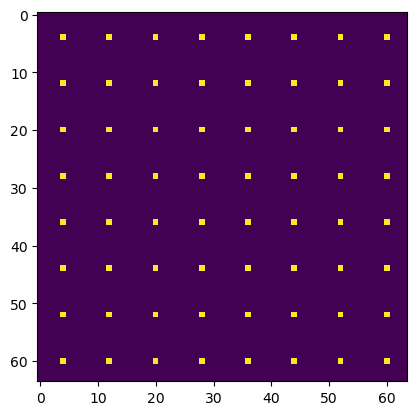

In [31]:
rmax            = 50
zemission       =  5 
nbins           = 2**6
binsize         = 2*rmax/nbins
xbins           = -rmax + np.arange(nbins+1)*binsize
ybins           = xbins
xybins          = xbins, ybins
sampling_freq   = 8
sampling_offset = sampling_freq//2
mask1d          = ((sampling_offset + np.arange(xbins.size-1)) % sampling_freq == 0)
nsipms_axis     = np.count_nonzero(mask1d)
nsipms          = nsipms_axis**2
xmask           = np.repeat(mask1d, nbins).reshape(nbins, nbins)
ymask           = np.tile  (mask1d, nbins).reshape(nbins, nbins)
mask            = xmask & ymask
plt.imshow(mask.astype(int))

In [32]:
def generate_flash(x0=0, y0=0, z0=zemission, n=10**6):
    costheta = np.random.uniform(0,       1, size=n)
    phi      = np.random.uniform(0, 2*np.pi, size=n)
    x        = z0 * (costheta**-2-1)**0.5 * np.cos(phi)
    y        = x  * np.tan(phi)
    x += x0
    y += y0
    return x, y

def generate_image(x, y):
    counts = np.histogram2d(x, y, xybins)[0].astype(np.float32)
    masked = counts[mask].reshape(nsipms_axis, nsipms_axis)
    return counts, masked

def generate_event(*args, **kwargs):
    x, y = generate_flash(*args, **kwargs)
    return generate_image(x, y)

# Demo

In [33]:
x, y = generate_flash(5, -11)
a, b = generate_image(x, y)

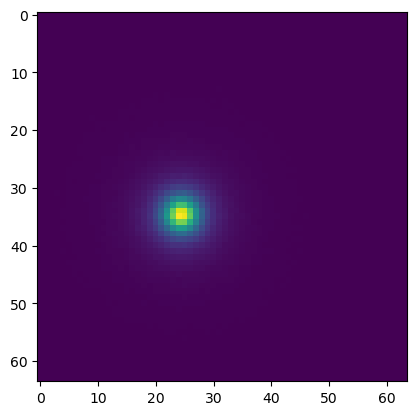

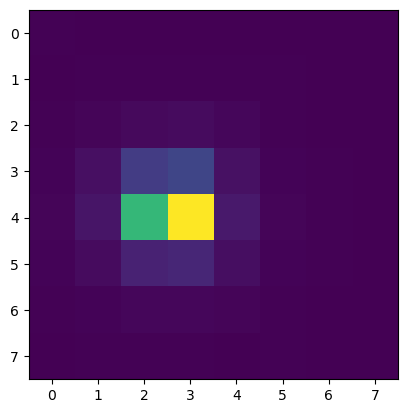

In [34]:
plt.imshow(a), plt.figure(), plt.imshow(b);

# NN architecture

In [65]:
class NN_v0(nn.Module):
    def __init__(self):
        super().__init__()
        size     = 2**6
        self.layer1 = nn.Conv2d     (     1, nsipms, nsipms*2, padding=1, dtype=torch.float64)
        self.norm1  = nn.BatchNorm2d(size*1,                       dtype=torch.float64)
        self.layer2 = nn.Conv2d     (size*1, size*2, 3, padding=1, dtype=torch.float64)
        self.norm2  = nn.BatchNorm2d(size*2,                       dtype=torch.float64)
        self.layer3 = nn.Conv2d     (size*2, size*4, 2, padding=1, dtype=torch.float64)
        self.norm3  = nn.BatchNorm2d(size*4,                       dtype=torch.float64)
        self.layer4 = nn.Linear     (size*4, nout*2,               dtype=torch.float64)

        self.pool   = nn.MaxPool2d(2, 4)
        self.drop   = nn.Dropout(p=0.1)

    def forward(self, x):
        nsipms_side = self.nsipms_side
        x = x.reshape(len(x), 1, nsipms_side, nsipms_side)
        x = self.pool(self.norm1(fnal.leaky_relu(self.layer1(x))))
        x = self.pool(self.norm2(fnal.leaky_relu(self.layer2(x))))
        x = self.pool(self.norm3(fnal.leaky_relu(self.layer3(x))))
        x = x.flatten(start_dim=1)
        x =                                      self.layer4(x)
        return x

class NN_v1(nn.Module):
    def __init__(self):
        super().__init__()
        scale_factor = sampling_freq
        out          = scale_factor**2
        self.conv1 = nn.Conv2d(in_channels= 1, out_channels=64 , kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32 , kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=out, kernel_size=5, padding=2)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)

    def forward(self, x):
        x = x.reshape(*np.insert(np.shape(x), 1, 1));# print("reshape", x.shape)
        x = torch.relu(self.conv1(x))               ;# print("conv1", x.shape)
        x = torch.relu(self.conv2(x))               ;# print("conv2", x.shape)
        x = self.conv3(x)                           ;# print("conv3", x.shape)
        x = self.pixel_shuffle(x)                   ;# print("reshuffle", x.shape)
        return x

In [66]:
class DS(Dataset):
    def __len__(self):
        return 1

    def __getitem__(self, i):
        return generate_event()

In [67]:
ds = DS()

batch_size = 100

n_train = 800
n_valid = 100
n_test  = 100

idx_train = np.arange(n_train)
idx_valid = np.arange(n_valid) + n_train
idx_test  = np.arange(n_test ) + n_train + n_valid

ds_train = Subset(ds, idx_train); print(f"Training   data: {len(ds_train):>6d}")
ds_valid = Subset(ds, idx_valid); print(f"Validation data: {len(ds_valid):>6d}")
ds_test  = Subset(ds, idx_test ); print(f"Testing    data: {len(ds_test) :>6d}")

loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=False)
loader_valid = DataLoader(ds_valid, batch_size=batch_size, shuffle=False)
loader_test  = DataLoader(ds_test , batch_size=batch_size, shuffle=False)

Training   data:    800
Validation data:    100
Testing    data:    100


## Training

In [68]:
#########################################################################
# training

#torch.manual_seed(args.seed)

print("seed =", torch.initial_seed())
lr          = 1e-3
nepochs     = 20
model       = NN_v1()
lossf       = nn.MSELoss()
optimizer   = optim.Adam(model.parameters(), lr=lr)
losses      = defaultdict(list)

for epoch in range(1, 1+nepochs):
    t0 = time()
    model.train() # inform the model that we are training
    optimizer.zero_grad()
    for i, (image, sipms) in enumerate(loader_train, start=1):
        prediction = model(sipms)
        loss       = lossf(prediction, image)
        loss     .backward()
        optimizer.step()

        losses[epoch].append(loss.data.item())

    validation_loss = []
    with torch.no_grad():
        model.eval() # tell the model that we are evaluating
        for i, (image, sipms) in enumerate(loader_valid, start=1):
            prediction = model(sipms)
            loss       = lossf(prediction, image)
            validation_loss.append(loss.data.item())

    dt = time() - t0
    print(f"Epoch [{epoch}/{nepochs}], Loss: {losses[epoch][-1]:.4f}, Val loss: {np.mean(validation_loss):.1f}, LR: {lr : .4f} DT : {dt:.1f}")

seed = 14285152040319158614


/nix/store/kms0fpbbq2w006c97jsi0glzfmcakvq0-python3-3.10.13-env/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([100, 64, 64])) that is different to the input size (torch.Size([100, 1, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/20], Loss: 894761.1875, Val loss: 808354.7, LR:  0.0010 DT : 175.0


KeyboardInterrupt: 

In [ ]:
#########################################################################
# testing

plt.figure()
for ie, ep in sorted(losses.items()):
    plt.plot(np.arange(len(ep))+ie*len(ep), ep)

plt.savefig(args.output_folder / "loss.png")


dxs, dys, dps, ps = [[] for i in range(4)]
with torch.no_grad():
    model.eval()
    for pos, response in loader_test:
        predicted = model(response)
        dx, dy    = (predicted - pos).numpy().T
        dxs.extend(dx)
        dys.extend(dy)
        dps.extend((dx**2 + dy**2)**0.5)
        ps.extend((pos**2).sum(axis=1)**0.5)

bins_dxy = np.linspace(-2, 2, 101)
bins_dr  = np.linspace( 0, 2, 101)
normhist = lambda x, b: plt.hist(x, b, weights=np.full(len(x), 100/len(x)))

plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1); normhist(dxs, bins_dxy); plt.xlabel("dx (mm)"); plt.ylabel("Fraction of events (%)")
plt.subplot(2, 2, 2); normhist(dys, bins_dxy); plt.xlabel("dy (mm)"); plt.ylabel("Fraction of events (%)")
plt.subplot(2, 2, 3); normhist(dps, bins_dr ); plt.xlabel(r"d$\rho$ (mm)"); plt.ylabel("Fraction of events (%)")
plt.subplot(2, 2, 4); plt.hist2d(dxs, dys, (bins_dxy,)*2, cmin=1); plt.xlabel("x (mm)"); plt.ylabel("y (mm)")

plt.tight_layout()
plt.savefig(args.output_folder / "deltas.png")

plt.figure()
bins_r = np.linspace(0, bins_dxy.max(), 101)
plt.hist2d(ps, dps, (bins_r, bins_dr), cmin=1)
plt.xlabel(r"$\rho$ (mm)")
plt.ylabel(r"d$\rho$ (mm)")
plt.savefig(args.output_folder / "deltap_p.png")


torch.save(model, args.output_folder / "model.nn")